In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image
import os
import PIL
import PIL.Image
import sys
import glob
from pathlib import Path


# Get the path of the dataset
os.chdir(sys.path[0])
working_directory = os.getcwd()
print(working_directory)
data_path = Path(working_directory + r"/dataset/IMG_CLASSES")

# Count the number of images within the  dataset
image_count = len(list(data_path.glob('*/*.jpg')))
print("The number of images in the dataset is " + str(image_count))

# Batch size and dimensions
batch_size = 30
IMG_SIZE = (150,150)

#Assigning the data splits and seed
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=IMG_SIZE,
    batch_size=batch_size
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=batch_size
)

d:\VIP_Project\submission
The number of images in the dataset is 27153
Found 27153 files belonging to 10 classes.
Using 21723 files for training.
Found 27153 files belonging to 10 classes.
Using 5430 files for validation.


In [2]:
data_augmentation = keras.Sequential([
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1),
])

In [3]:
#transfer learning using xception
#Preprocessing the data
preprocess_input = tf.keras.applications.xception.preprocess_input

In [4]:
IMG_SIZE = (150,150)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.xception.Xception(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet',
                                               classes=10
                                              )

#freeze all the layer
for layer in base_model.layers:
    layer.trainable = False

In [6]:
base_model.summary()
base_model.get_layer('block14_sepconv2_act').output

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 74, 74, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                           

<KerasTensor: shape=(None, 5, 5, 2048) dtype=float32 (created by layer 'block14_sepconv2_act')>

In [6]:
inputs = tf.keras.Input(shape=(150,150, 3))

x = preprocess_input(inputs)
x = data_augmentation(x)
x = base_model(x, training=False)

# Flatten the output layer to 1 dimension
x = layers.Flatten()(x)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.7
x = layers.Dropout(0.7)(x)

predictions = layers.Dense(10, activation='softmax')(x)

# Configure and compile the model

model = keras.Model(inputs, predictions)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])


In [7]:
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=validation_dataset,
                    batch_size = 64
                   )

Epoch 1/5
725/725 [==============================] - 61s 73ms/step - loss: 2.0553 - accuracy: 0.3694 - val_loss: 1.4120 - val_accuracy: 0.4477
Epoch 2/5
725/725 [==============================] - 54s 74ms/step - loss: 1.5783 - accuracy: 0.4004 - val_loss: 1.2897 - val_accuracy: 0.4692
Epoch 3/5
725/725 [==============================] - 53s 73ms/step - loss: 1.5433 - accuracy: 0.4045 - val_loss: 1.2564 - val_accuracy: 0.4726
Epoch 4/5
725/725 [==============================] - 55s 75ms/step - loss: 1.5376 - accuracy: 0.4138 - val_loss: 1.2114 - val_accuracy: 0.4961
Epoch 5/5
725/725 [==============================] - 56s 77ms/step - loss: 1.5352 - accuracy: 0.4206 - val_loss: 1.2755 - val_accuracy: 0.4858


In [8]:
for layer in base_model.layers[-30:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

    
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

In [9]:
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=2)

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 150, 150, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 150, 150, 3)      0         
 a)                                                              
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 51200)             0     

In [11]:
history_unfreeze = model.fit(train_dataset,
                    epochs=30,
                    validation_data=validation_dataset,
                    callbacks = [learning_rate_reduction]
)

Epoch 1/30
725/725 [==============================] - 79s 104ms/step - loss: 1.2942 - accuracy: 0.5061 - val_loss: 0.9850 - val_accuracy: 0.6138 - lr: 1.0000e-04
Epoch 2/30
725/725 [==============================] - 74s 101ms/step - loss: 1.0464 - accuracy: 0.5979 - val_loss: 0.8709 - val_accuracy: 0.6604 - lr: 1.0000e-04
Epoch 3/30
725/725 [==============================] - 74s 101ms/step - loss: 0.9229 - accuracy: 0.6532 - val_loss: 0.8313 - val_accuracy: 0.6681 - lr: 1.0000e-04
Epoch 4/30
725/725 [==============================] - 74s 102ms/step - loss: 0.8490 - accuracy: 0.6850 - val_loss: 0.7763 - val_accuracy: 0.6941 - lr: 1.0000e-04
Epoch 5/30
725/725 [==============================] - 74s 102ms/step - loss: 0.7749 - accuracy: 0.7122 - val_loss: 0.7458 - val_accuracy: 0.7144 - lr: 1.0000e-04
Epoch 6/30
725/725 [==============================] - 76s 104ms/step - loss: 0.7334 - accuracy: 0.7323 - val_loss: 0.7609 - val_accuracy: 0.7215 - lr: 1.0000e-04
Epoch 7/30
725/725 [========

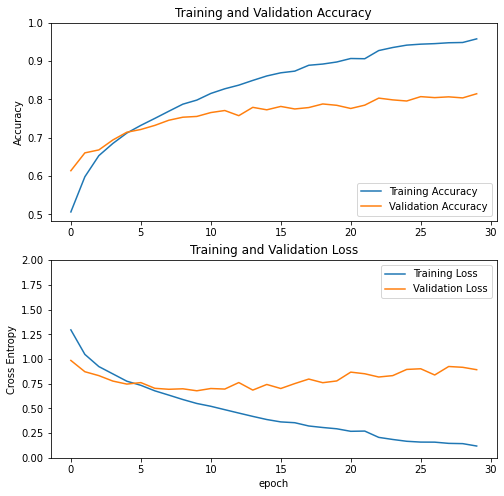

C:\Users\user\anaconda3\envs\tf\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [12]:
acc = history_unfreeze.history['accuracy']
val_acc = history_unfreeze.history['val_accuracy']

loss = history_unfreeze.history['loss']
val_loss = history_unfreeze.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig('xception_net score.png')
plt.show()

model.save("xception_net.h5")

In [13]:
import pandas as pd
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history_unfreeze.history) 

# save to json:  
hist_json_file = 'xception_finetune_history.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)
    
hist_csv_file = 'xception_finetune_history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)